In [1]:
# 1. Basic comparison metrics across industries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import re
from scipy.stats import median_abs_deviation
from sklearn.ensemble import IsolationForest
from ipywidgets import interact, widgets, Button, Output, VBox


# Define file paths for all datasets
file_paths = {
    "balance_sheet": "Balance_Sheet_final.csv",
    "annual_p_l_1": "Annual_P_L_1_final.csv",
    "annual_p_l_2": "Annual_P_L_2_final.csv",
    "quarter_p_l_1": "Quarter_P_L_1_final.csv",
    "quarter_p_l_2": "Quarter_P_L_2_final.csv",
    "cash_flow": "cash_flow_statments_final.csv",
    "other_metrics": "other_metrics_final.csv",
    "price": "price_final.csv",
    "ratios_1": "ratios_1_final.csv",
    "ratios_2": "ratios_2_final.csv",
    "t1_prices": "t1_prices.csv"
}

# Load all datasets
datasets = {name: pd.read_csv(path) for name, path in file_paths.items()}

merged_data = datasets["balance_sheet"]

# List of dataset names to merge (excluding 'balance_sheet' since it's already included)
dataset_names = ["annual_p_l_1", "annual_p_l_2", "quarter_p_l_1", "quarter_p_l_2", 
                 "cash_flow", "other_metrics", "price", "ratios_1", "ratios_2", "t1_prices"]

# Merge each dataset on the 'join_key' column
for name in dataset_names:
    merged_data = pd.merge(merged_data, datasets[name], on="join_key", how="outer")

# Remove duplicate columns
merged_data = merged_data.loc[:, ~merged_data.columns.duplicated()]

merged_data = merged_data.drop('Credit rating', axis=1)
# Fill missing values for numerical columns
numerical_columns = merged_data.select_dtypes(include=['float64', 'int64']).columns

# Group data by industry
# Drop rows where 'Industry_x' is NaN
filtered_data = merged_data.dropna(subset=["Industry_x"])

# Define the key metrics
key_metrics = [
    "Market Capitalization_x", "Price to Earning", "Dividend yield",
    "Return on equity", "Return on assets", "OPM preceding quarter",
    "Sales growth 3Years", "Profit growth 3Years", "EPS growth 3Years",
    "Current ratio", "Quick ratio", "Debt to equity",
    "Price to Free Cash Flow", "Enterprise Value to EBIT", "PB X PE",
    "Inventory turnover ratio", "Working Capital to Sales ratio", "Asset Turnover Ratio",
    "Debt To Profit", "Interest Coverage Ratio", "Return over 1year", "Volume 1month average", "Altman Z Score",
    "Piotroski score", "Intrinsic Value", "join_key", "Industry_x", "Name_x", "General_Industry"
]
regex_patterns = {
    "Technology & IT": r"(Computers|Electronics|Telecommunications|Electric|Appliances|Air-conditioners|Cables|Media)",
    "Finance & Banking": r"(Banks|Finance|Investments|Housing|Term-Lending|Trading)",
    "Healthcare & Pharmaceuticals": r"(Healthcare|Pharmaceuticals|Chemicals|Dyes|Pigments)",
    "Manufacturing & Engineering": r"(Engineering|Steel|Electrodes|Castings|Machinery|Compressors|Towers|Equipment|Engines|Pumps|Fasteners|Bearings|Packaging|Plastics)",
    "Energy & Utilities": r"(Power|Oil|Petrochemicals|Refineries|Cement|Chlor|Refractories|Tiles|Sanitaryware|Glass|Aluminium|Mining)",
    "Consumer Goods": r"(Textiles|Automobiles|Tyres|Cigarettes|Dry Cells|Breweries|Detergents|Ancillaries|Paints|Recreation)",
    "Retail & Lifestyle": r"(Diamond|Personal|Leather|Luggage|Hotels|Travel|Entertainment)",
    "Agriculture & Food": r"(Food|Fertilizers|Pesticides|Aquaculture|Sugar|Tea|Paper)",
    "Transport & Logistics": r"(Transport|Shipping|Couriers)"
}

# Function to classify based on regex patterns
def classify_industry(industry_name):
    for general_industry, pattern in regex_patterns.items():
        if re.search(pattern, industry_name, re.IGNORECASE):
            return general_industry
    return "Other"  # Default category if no match is found
    
# Apply the classification function
merged_data["General_Industry"] = merged_data["Industry_x"].apply(classify_industry)

# Drop industries with minimal instances
merged_data = merged_data.loc[merged_data['General_Industry'] != 'Other']
merged_data = merged_data.loc[merged_data['General_Industry'] != 'Transport & Logistics']

numerical_columns = merged_data.select_dtypes(include=['float64', 'int64']).columns
grouped_data = merged_data.groupby('General_Industry')
# Fill NaN values within each industry
for col in numerical_columns:
    merged_data[col] = grouped_data[col].transform(lambda x: x.fillna(x.median()))

#Display instances by industry
value_counts = merged_data['General_Industry'].value_counts()
print("3844 companies were separated into 'General Industry' categories\n\n\nDistributions:\n")
print(value_counts)

print("\n------------------------------------------------------------------------------------------------------------------\n")

filtered_data = merged_data[key_metrics]

filtered_data = filtered_data.rename(columns={"Market Capitalization_x": "Market Capitilization"})
numerical_columns = filtered_data.select_dtypes(include=['float64', 'int64']).columns
iso_forest = IsolationForest(contamination=0.01, random_state=42)
outliers = iso_forest.fit_predict(filtered_data[numerical_columns])

# Keep only inliers
filtered_data = filtered_data[outliers == 1]
# Recalculate mean metrics by industry after outlier removal
industry_means = filtered_data.groupby("General_Industry")[numerical_columns].mean()

boxplot_output = Output()
means_output = Output()

# Define the interactive plotting function
def plot_metric_distribution(metric):
    """
    Plot a boxplot of the selected metric across industries.
    """
    lower_percentile = filtered_data[metric].quantile(0.02)
    upper_percentile = filtered_data[metric].quantile(0.98)


    plt.figure(figsize=(12, 6))
    sns.boxplot(data=filtered_data, x="General_Industry", y=metric, palette="Set2")
    plt.title(f"Distribution of {metric} Across Industries", fontsize=14)
    plt.xlabel("Industry", fontsize=12)
    plt.ylabel(metric, fontsize=12)
    plt.xticks(rotation=45, fontsize=10)
    plt.tight_layout()
    plt.ylim(lower_percentile, upper_percentile)
    plt.show()

# Function to update the plot and means
def update_plot_and_means(change):
    # Update boxplot
    boxplot_output.clear_output()
    with boxplot_output:
        plot_metric_distribution(change.new)
    
    # Update means
    means_output.clear_output()
    formatted_means = industry_means[[change.new]].rename(columns={change.new: f"Mean {change.new}"})
    styled_means = formatted_means.style.apply(lambda x: ['background-color: lightgreen' if v == x.max() 
                                                          else 'background-color: lightcoral' if v == x.min() 
                                                          else '' for v in x], axis=0)
    with means_output:
        display(styled_means)


# Create an interactive widget for metric selection
metric_selector = widgets.Dropdown(
    options=numerical_columns,
    value=numerical_columns[3],
    description='CHOOSE METRIC:',
    style={'description_width': 'initial'}
)

# Attach observer to the dropdown
metric_selector.observe(update_plot_and_means, names='value')

# Initialize the display with the first metric
initial_metric = numerical_columns[3]
with boxplot_output:
    plot_metric_distribution(initial_metric)
with means_output:
    industry_means = industry_means.rename_axis("Industry", axis="index")

    formatted_means = industry_means[[initial_metric]].rename(columns={initial_metric: f"Mean {initial_metric}"})
    styled_means = formatted_means.style.apply(
        lambda x: [
            'background-color: lightgreen' if v == x.max() else
            'background-color: lightcoral' if v == x.min() else ''
            for v in x
        ],
        axis=0
)
    from IPython.display import display_html
    display_html(styled_means._repr_html_(), raw=True)

# Display all widgets and outputs
VBox([metric_selector, boxplot_output, means_output])

3844 companies were separated into 'General Industry' categories


Distributions:

Finance & Banking               1160
Technology & IT                  586
Manufacturing & Engineering      568
Energy & Utilities               497
Healthcare & Pharmaceuticals     449
Agriculture & Food               242
Consumer Goods                   180
Retail & Lifestyle               162
Name: General_Industry, dtype: int64

------------------------------------------------------------------------------------------------------------------



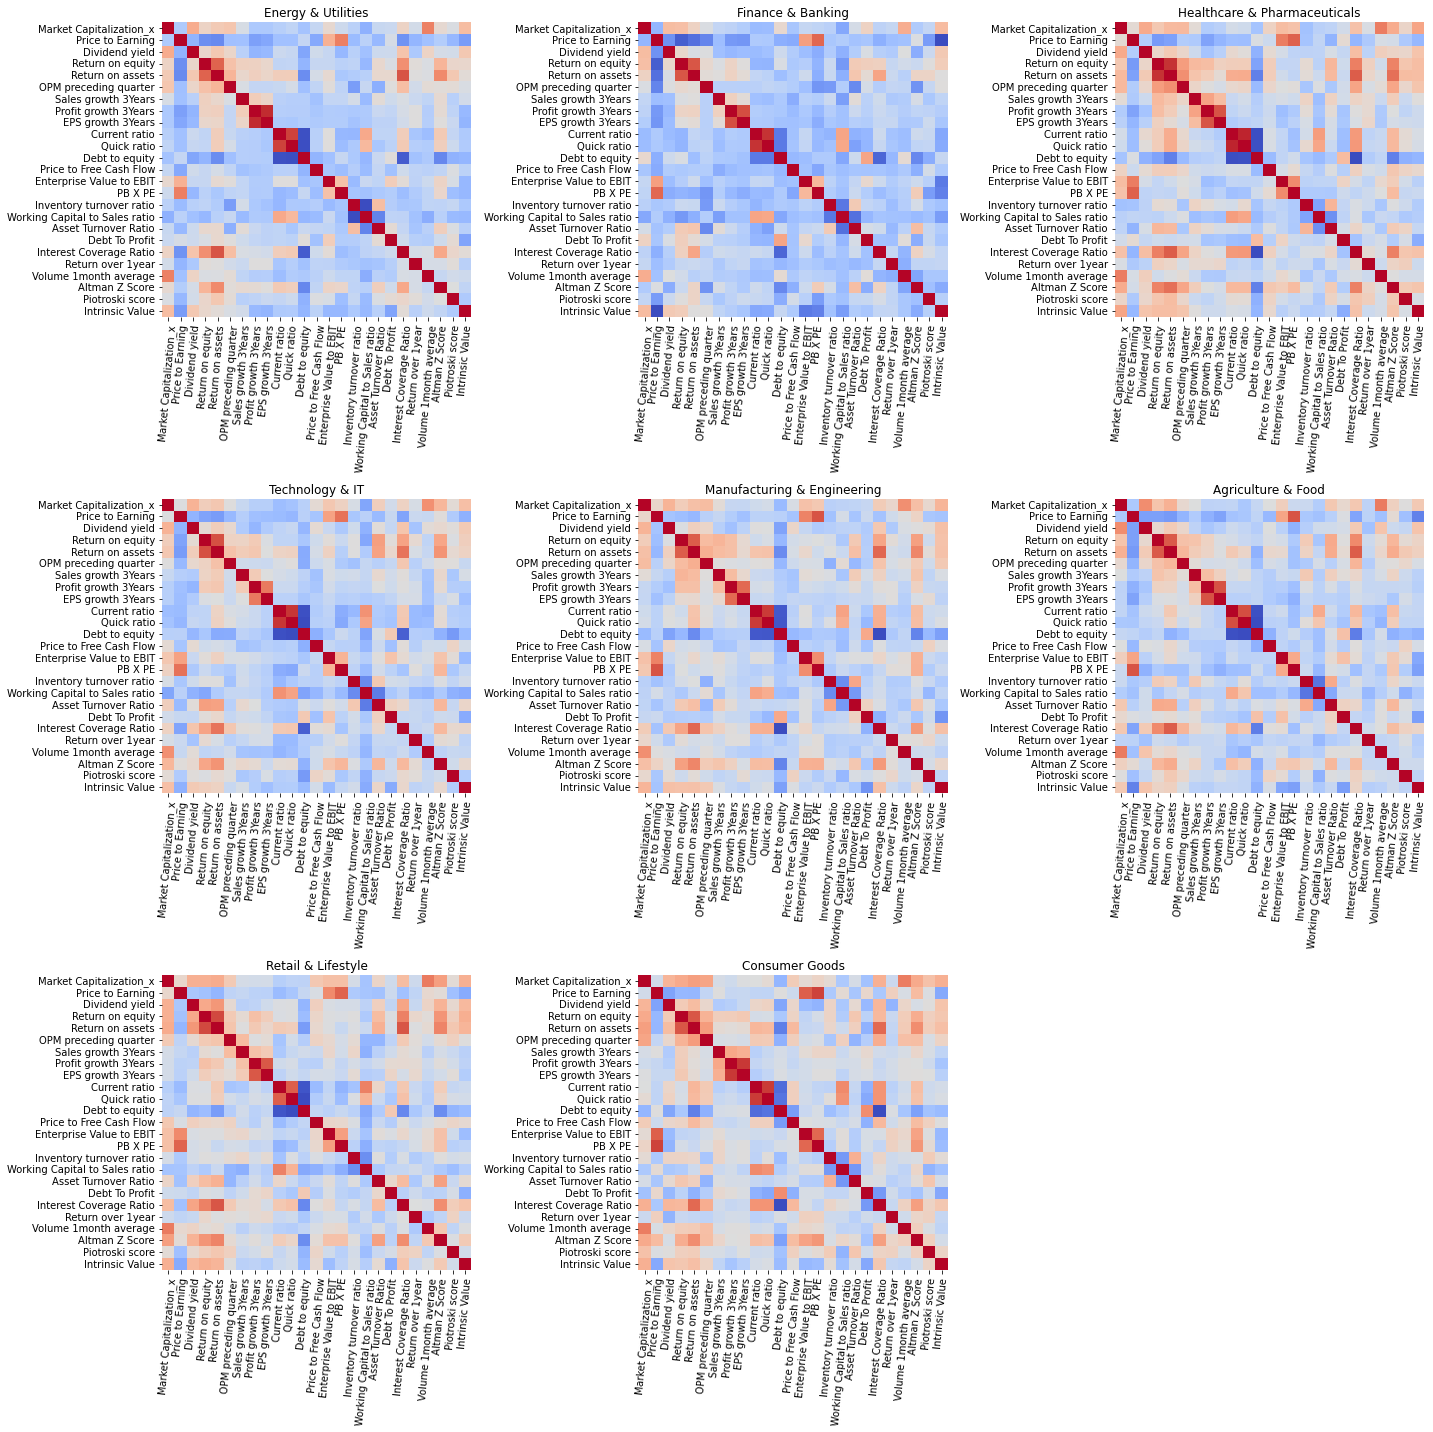

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

heatmap_data = merged_data[key_metrics]
industries = heatmap_data["General_Industry"].unique()

num_industries = len(industries)
rows = 3
cols = (num_industries + rows - 1) // rows 

fig, axes = plt.subplots(rows, cols, figsize=(20, 20))  

axes = axes.flatten()

for i, industry in enumerate(industries):
    industry_data = heatmap_data[heatmap_data["General_Industry"] == industry]

    numerical_columns = industry_data.select_dtypes(include=['float64', 'int64']).columns

    correlation_matrix = industry_data[numerical_columns].corr(method="spearman")

    sns.heatmap(
        correlation_matrix,
        annot=False,  
        fmt=".1f", 
        cmap="coolwarm", 
        cbar=False, 
        ax=axes[i] 
    )
    axes[i].set_title(f"{industry}", fontsize=12)
    axes[i].tick_params(axis='x', labelrotation=85)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


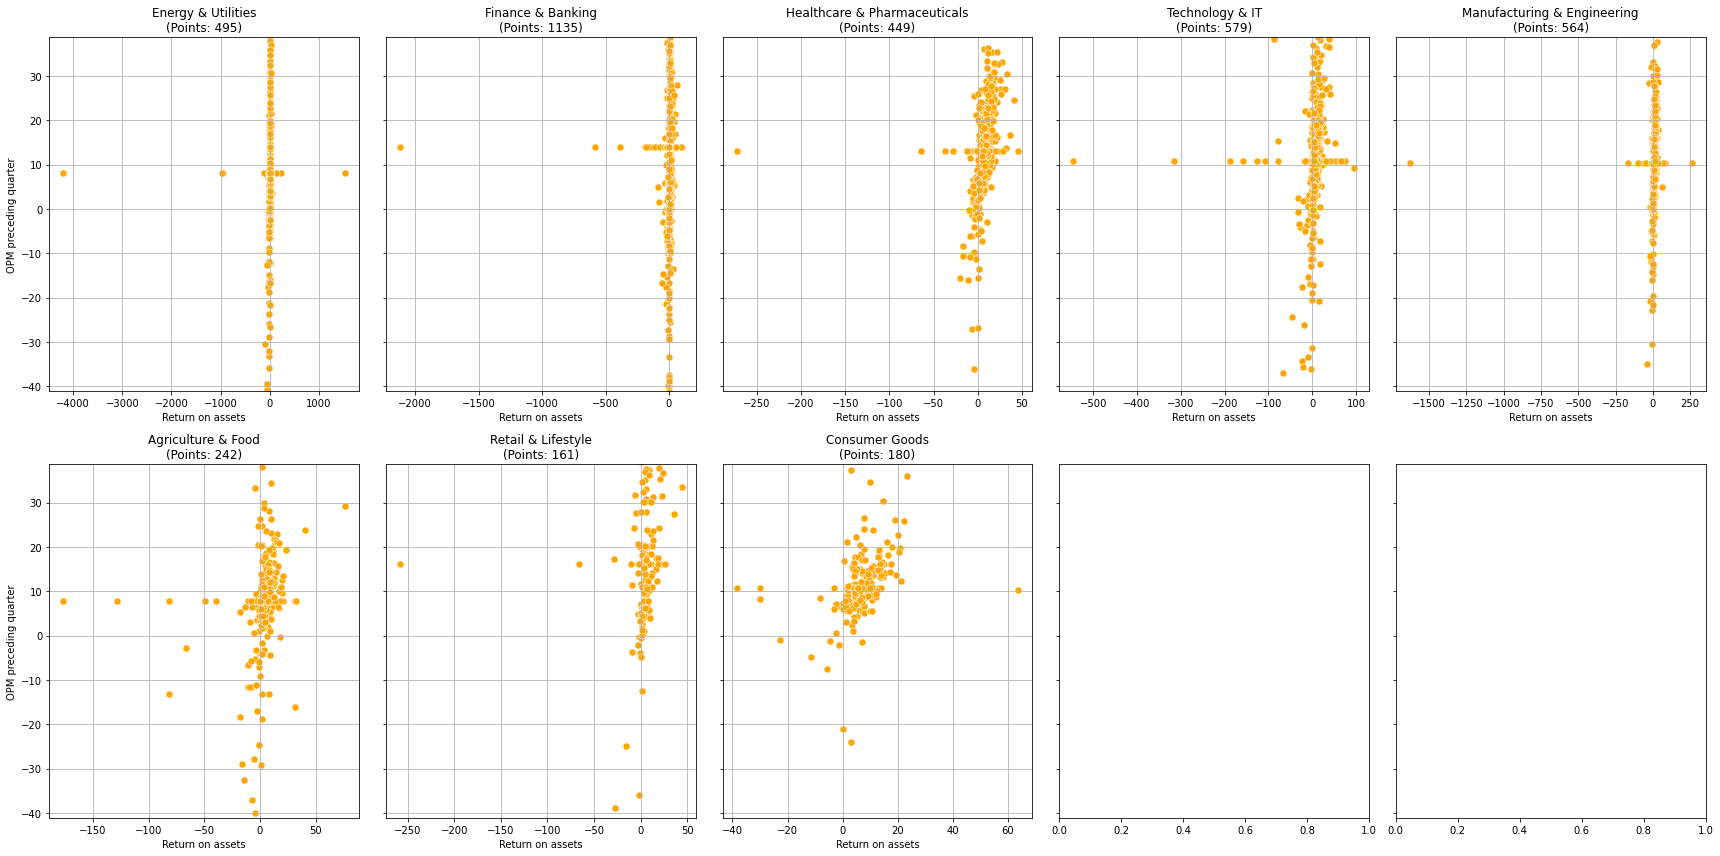

In [3]:
grouped_data = filtered_data.groupby("General_Industry")
industries = filtered_data["General_Industry"].unique()

fig, axes = plt.subplots(2, 5, figsize=(24, 12), sharey=True)

# easier iteration
axes = axes.flatten()

# Iterate through each industry and plot
for i, industry in enumerate(industries):
    ax = axes[i]  # Access the corresponding subplot axis
    industry_data = grouped_data.get_group(industry)
    num_points = len(industry_data)


    sns.scatterplot(
        data=industry_data,
        x="Return on assets",
        y="OPM preceding quarter",
        ax=ax,
        color="orange",
        s=50
    )
    
    lower_percentile = industry_data["OPM preceding quarter"].quantile(0.01)
    upper_percentile = industry_data["OPM preceding quarter"].quantile(0.99)

    ax.set_title(industry, fontsize=12)
    ax.set_title(f"{industry}\n(Points: {num_points})", fontsize=12)
    ax.set_xlabel("Return on assets", fontsize=10)
    ax.set_ylabel("OPM preceding quarter", fontsize=10)
    ax.grid(True)
    plt.ylim(lower_percentile, upper_percentile)


plt.tight_layout()
plt.show()

*Reasons for Stronger Correlation in Consumer Goods

Asset-Intensive Nature:
Consumer goods companies rely heavily on physical assets such as factories, distribution networks, and inventory.
Efficient utilization of these assets directly impacts profitability, linking ROA and OPM.

Brand Value and Pricing Power:
Strong brands in the consumer goods sector allow companies to maintain high-profit margins, which also boosts asset returns.
Consistency in Demand:

The consumer goods industry benefits from stable, recurring demand for essential products, which ensures steady operating performance and efficient asset utilization.

Economies of Scale:
Large-scale production and distribution improve efficiency, reducing costs and increasing both OPM and ROA.

*Reasons for Stronger Correlation in Healthcare & Pharmaceuticals

R&D Investments Driving Profitability:
Significant R&D expenditures lead to patent-protected products, resulting in high-profit margins (OPM).
These high-margin products contribute to efficient asset utilization, linking ROA and OPM.

High Margins on Patented Products:
Pharmaceutical products often enjoy monopoly pricing due to patents, leading to both higher OPM and better asset returns.
Efficient Production and Distribution:

Once a drug is approved, economies of scale in production and distribution further enhance asset utilization and profitability.
Recurring Revenue Streams:

Healthcare companies benefit from recurring income through long-term prescriptions and treatment programs, supporting both high OPM and ROA.


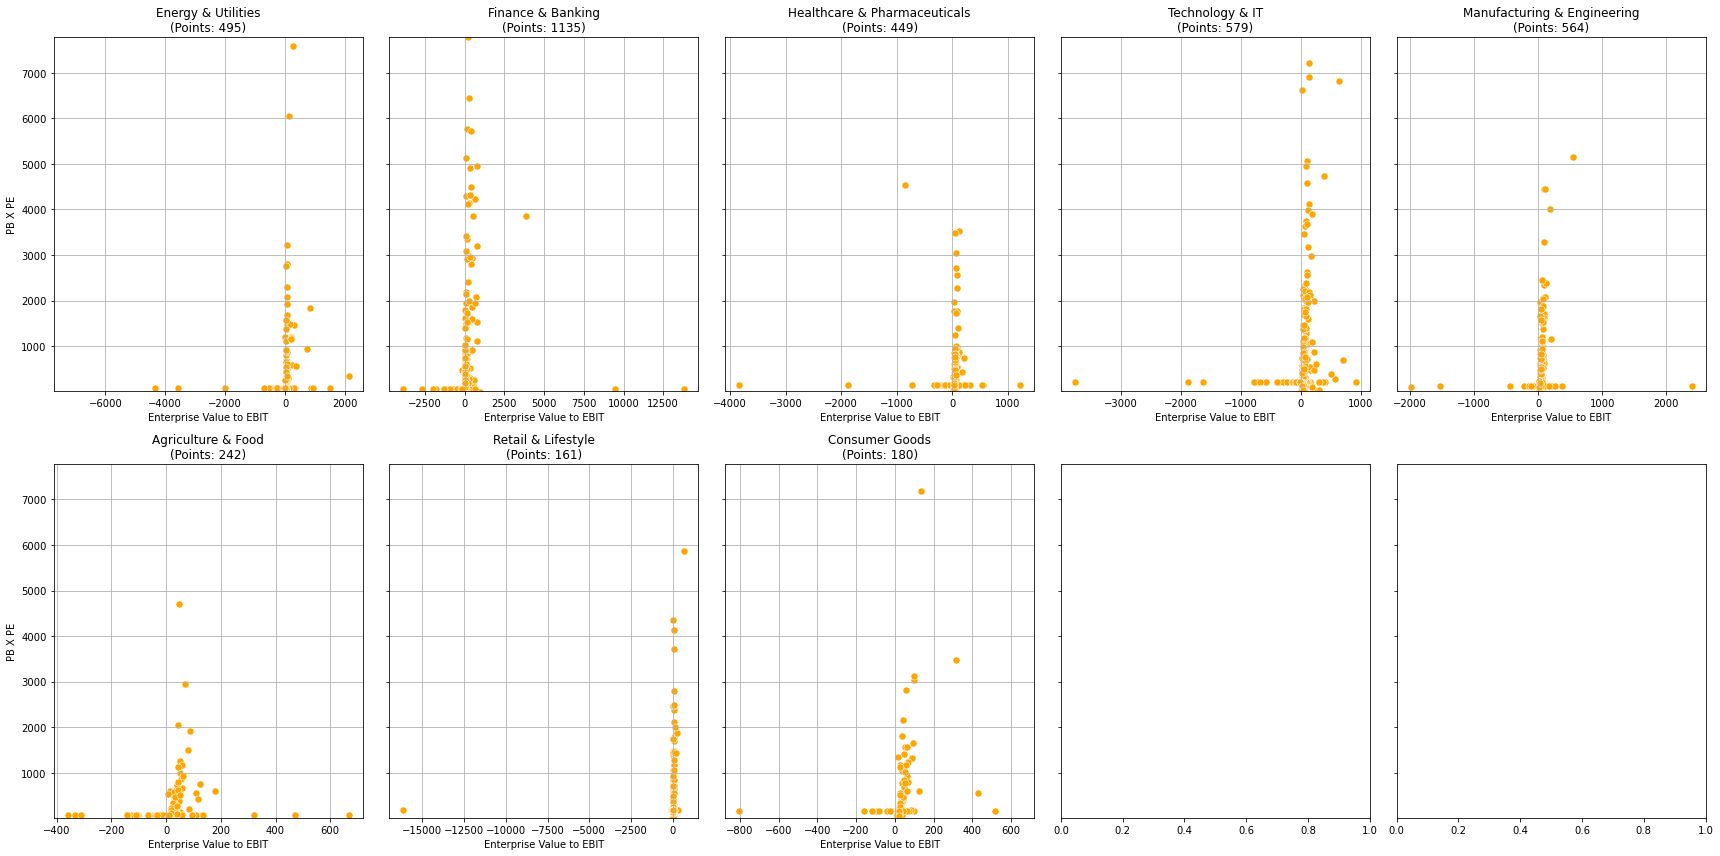

In [4]:
grouped_data = filtered_data.groupby("General_Industry")
industries = filtered_data["General_Industry"].unique()

fig, axes = plt.subplots(2, 5, figsize=(24, 12), sharey=True)

# easier itteration
axes = axes.flatten()

# Iterate through each industry and plot
for i, industry in enumerate(industries):
    ax = axes[i]  # Access the corresponding subplot axis
    industry_data = grouped_data.get_group(industry)
    num_points = len(industry_data)


    sns.scatterplot(
        data=industry_data,
        x="Enterprise Value to EBIT",
        y="PB X PE",
        ax=ax,
        color="orange",
        s=50
    )
    
    lower_percentile = industry_data["PB X PE"].quantile(0.01)
    upper_percentile = industry_data["PB X PE"].quantile(0.99)

    ax.set_title(industry, fontsize=12)
    ax.set_title(f"{industry}\n(Points: {num_points})", fontsize=12)
    ax.set_xlabel("Enterprise Value to EBIT", fontsize=10)
    ax.set_ylabel("PB X PE", fontsize=10)
    ax.grid(True)
    plt.ylim(lower_percentile, upper_percentile)

plt.tight_layout()
plt.show()

A correlation coefficient of 0.8 suggests a strong positive linear relationship between Enterprise Value to EBIT (EV/EBIT) and Price-to-Book x Price-to-Earnings (PB X PE) within the consumer goods industry.

Stability of Financial Metrics:

Consumer Goods companies generally operate in a predictable and stable environment, with consistent earnings and margins.
This stability reduces noise and increases alignment between valuation metrics like PB X PE and Enterprise Value to EBIT.

Investors' Valuation Behavior:

In Consumer Goods, PB X PE reflects investors' willingness to pay for future growth or brand value.
Simultaneously, Enterprise Value to EBIT provides insight into operational efficiency and leverage. The alignment between these metrics indicates a consensus among investors on how to value companies in this sector.

Asset-Intensive Nature:

Consumer Goods companies often have substantial tangible assets (e.g., factories, distribution networks), which contribute to both enterprise value and book value.
This common dependence on assets further strengthens the correlation.
Impact of Brand Value:

Many Consumer Goods companies derive significant value from intangible assets such as brand reputation. Investors may use PB X PE as a proxy for brand value, which tends to correlate with overall enterprise value.

Original data rows: 3844
All missing values have been handled.


Accordion(children=(Output(),), titles=('Selected Features (50)',))

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Classification Report:
                              precision    recall  f1-score   support

          Agriculture & Food       0.78      0.66      0.71        32
              Consumer Goods       0.74      0.52      0.61        27
          Energy & Utilities       0.71      0.83      0.77        60
           Finance & Banking       0.96      0.96      0.96       183
Healthcare & Pharmaceuticals       0.68      0.75      0.71        67
 Manufacturing & Engineering       0.66      0.74      0.70        82
          Retail & Lifestyle       0.93      0.64      0.76        22
             Technology & IT       0.95      0.88      0.91        98

                    accuracy                           0.83       571
                   macro avg       0.80      0.75      0.77       571
                weighted avg       0.83      0.83      0.83       571



Text(0.5, 1.0, 'Confusion Matrix')

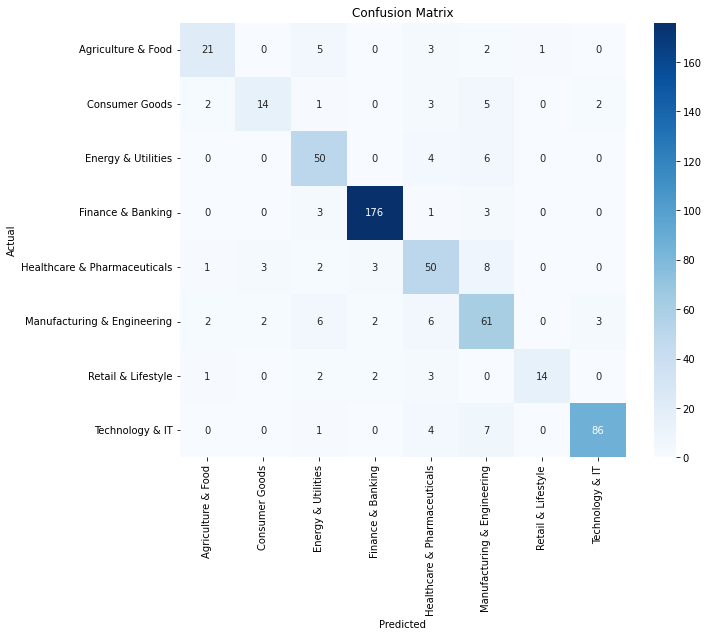

In [5]:
# MACHINE LEARNING MODEL 
# - Predicts industry based on metrics
# - Ensemble model

import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from lightgbm import LGBMClassifier
import lightgbm as lgb
from itertools import product
from sklearn.ensemble import IsolationForest
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from sklearn.metrics import make_scorer, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.ensemble import GradientBoostingClassifier


# Apply the classification function
merged_data = merged_data.loc[:, ~(merged_data.columns.str.contains("industry", case=False) & (merged_data.columns != "General_Industry"))]
print(f"Original data rows:", merged_data.shape[0])
filtered_data = filtered_data.rename(columns={"Market Capitilization": "Market Capitilization_x"})

# Define target and features
target = "General_Industry"
exclude_columns = ["Name_x", "BSE Code_x", "BSE Code_y", "Depreciation preceding year", "Depreciation latest quarter", target]  # Columns to exclude

if merged_data.isnull().sum().sum() > 0:
    print("Warning: There are still NaN values in the dataset!")
else:
    print("All missing values have been handled.")
    
numerical_columns = merged_data.select_dtypes(include=["float64", "int64"]).columns

iso_forest = IsolationForest(contamination=0.01, random_state=42)
outliers = iso_forest.fit_predict(merged_data[numerical_columns])

merged_data = merged_data[outliers == 1]

# Ensure only numerical columns are included 
features = [col for col in numerical_columns if col not in exclude_columns]
X = merged_data[features]
y = merged_data[target]

# Encode target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Feature selection with SelectKBest
selector = SelectKBest(mutual_info_classif, k=50)
X_selected = selector.fit_transform(X, y_encoded)

selected_features = [features[i] for i in selector.get_support(indices=True)]
accordion = widgets.Accordion(children=[widgets.Output()])
accordion.set_title(0, f"Selected Features ({len(selected_features)})")

with accordion.children[0]:
    print(selected_features)
display(accordion)


X_train, X_test, y_train, y_test = train_test_split(X_selected, y_encoded, test_size=0.15, random_state=42)

# Manually assign and adjust class weights
class_weights = {class_idx: 1 for class_idx in range(len(label_encoder.classes_))}

label_encoder.transform(["Agriculture & Food"])[0]: 3.5
label_encoder.transform(["Consumer Goods"])[0]: 3.2
label_encoder.transform(["Energy & Utilities"])[0]: 2.0
label_encoder.transform(["Finance & Banking"])[0]: 0.3
label_encoder.transform(["Healthcare & Pharmaceuticals"])[0]: 2.1
label_encoder.transform(["Manufacturing & Engineering"])[0]: 1.8
label_encoder.transform(["Retail & Lifestyle"])[0]: 2.25
label_encoder.transform(["Technology & IT"])[0]: 1.0

# Define individual models
lightgbm = LGBMClassifier(random_state=42, class_weight=class_weights, verbose=-1)
log_reg = LogisticRegression(max_iter=1000, random_state=42, class_weight=class_weights)
random_forest = RandomForestClassifier(random_state=42, class_weight=class_weights)
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric="mlogloss")
gradient_boosting = GradientBoostingClassifier(random_state=42)

# STACKING ENSEMBLE
stacking_ensemble = StackingClassifier(
    estimators=[
        ('lgbm', lightgbm),
        ('log_reg', log_reg),
        ('rf', random_forest),
        #('xgb', xgb),
        ('gb', gradient_boosting)
    ],
    final_estimator=LogisticRegression(max_iter=1000, random_state=42)
)

pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Feature scaling
    ('ensemble', stacking_ensemble)  # Stacking ensemble
])

param_grid = {
    'ensemble__lgbm__num_leaves': [60],
    'ensemble__lgbm__learning_rate': [0.1],
    'ensemble__lgbm__n_estimators': [100],
    #'ensemble__xgb__max_depth': [5],
    #'ensemble__xgb__learning_rate': [0.01],
    #'ensemble__xgb__n_estimators': [200],
    'ensemble__rf__n_estimators': [200],
    'ensemble__rf__max_depth': [15],
    'ensemble__gb__n_estimators': [100],
    'ensemble__gb__learning_rate': [0.1],
}

# SCORER
f1_scorer = make_scorer(f1_score, average='weighted')

random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_grid,
    n_iter=25,  # Adjust for faster results
    scoring=f1_scorer,
    cv=3,  # Cross-validation folds
    random_state=42,
    n_jobs=1,
    verbose=1
)

# Fit
random_search.fit(X_train, y_train)

best_model = random_search.best_estimator_

# Evaluate 
y_pred = best_model.predict(X_test)
target_names = label_encoder.inverse_transform(sorted(set(y_test)))

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=target_names))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")